
# GEFCom2012 – Decision Tree with Multi-lag Autoregressive Features (Station 3)

This notebook implements a **Decision Tree regression** model for wind power prediction
at station **3** (`wp3`), using both:

- **Forecast features** from ECMWF (u, v, ws, hors, time features), and  
- **Autoregressive features**: past values of `wp3`,

\[
wp3(t-1),\; wp3(t-2),\;\dots,\; wp3(t-n)
\]

where the number of lags \(n\) is controlled by the parameter `N_LAGS` (default: 3).

We will:

1. Load & align the **meteorological forecasts** and **power output**.  
2. Build wind + time + multi-lag autoregressive features.  
3. Compare:
   - **Persistence baseline** (`wp3(t) = wp3(t-1)`),  
   - **Basic DecisionTreeRegressor**,  
   - **Tuned DecisionTreeRegressor** (via GridSearchCV with TimeSeriesSplit).


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (8, 4)

# ---- Set number of lags here ----
N_LAGS = 1   # default, change this value to use more/less lags
print("Using N_LAGS =", N_LAGS)


Using N_LAGS = 1


## 1. Load and align data

In [2]:

DATA_DIR = Path("Wind")  # adapt this path if needed

train_path = DATA_DIR / "train.csv"
forecast_path = DATA_DIR / "windforecasts_wf3.csv"

print(train_path.resolve())
print(forecast_path.resolve())

# --- Load power data ---
df_power = pd.read_csv(train_path, delim_whitespace=True)
df_power["date"] = pd.to_datetime(df_power["date"], format="%Y%m%d%H")
df_power = df_power.set_index("date").sort_index()

# Focus on station 3
df_power = df_power[["wp3"]]

df_power.head()


C:\Users\henri\Desktop\PSC\Data-study\ForecastingData\Wind\train.csv
C:\Users\henri\Desktop\PSC\Data-study\ForecastingData\Wind\windforecasts_wf3.csv


C:\Users\henri\AppData\Local\Temp\ipykernel_17272\2551084748.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_power = pd.read_csv(train_path, delim_whitespace=True)


,wp3
date,
2009-07-01 00:00:00,0.494
2009-07-01 01:00:00,0.257
2009-07-01 02:00:00,0.178
2009-07-01 03:00:00,0.109
2009-07-01 04:00:00,0.079


In [3]:

# --- Load meteorological forecasts for wind farm 3 ---
df_fc = pd.read_csv(forecast_path)
df_fc["date"] = pd.to_datetime(df_fc["date"], format="%Y%m%d%H")

# Keep only short-term forecasts (1–12h ahead)
df_fc = df_fc[df_fc["hors"].between(1, 12)]

# Convert 'hors' into valid time (issue time + horizon)
df_fc["valid_time"] = df_fc["date"] + pd.to_timedelta(df_fc["hors"], unit="h")

# For each valid_time, keep the *shortest* horizon forecast
df_fc = df_fc.sort_values(["valid_time", "hors"])
df_fc_shortest = df_fc.groupby("valid_time").first().reset_index()

# Index by valid_time for alignment
df_fc_shortest = df_fc_shortest.set_index("valid_time").sort_index()

df_fc_shortest.head()


,date,hors,u,v,ws,wd
valid_time,,,,,,
2009-07-01 01:00:00,2009-07-01,1,3.51,-2.43,4.27,124.75
2009-07-01 02:00:00,2009-07-01,2,2.96,-2.12,3.65,125.63
2009-07-01 03:00:00,2009-07-01,3,2.47,-2.02,3.19,129.29
2009-07-01 04:00:00,2009-07-01,4,2.05,-2.06,2.90,135.14
2009-07-01 05:00:00,2009-07-01,5,1.72,-2.11,2.72,140.85


In [4]:

# --- Align forecasts with realized power ---
df = df_fc_shortest.join(df_power, how="inner")

print("Aligned shape:", df.shape)
print(df[["hors", "u", "v", "ws", "wd", "wp3"]].head())

# Drop any rows with missing core values
df = df.dropna(subset=["wp3", "u", "v", "ws"])
print("After dropping NAs:", df.shape)


Aligned shape: (13175, 7)
                     hors     u     v    ws      wd    wp3
2009-07-01 01:00:00     1  3.51 -2.43  4.27  124.75  0.257
2009-07-01 02:00:00     2  2.96 -2.12  3.65  125.63  0.178
2009-07-01 03:00:00     3  2.47 -2.02  3.19  129.29  0.109
2009-07-01 04:00:00     4  2.05 -2.06  2.90  135.14  0.079
2009-07-01 05:00:00     5  1.72 -2.11  2.72  140.85  0.099
After dropping NAs: (13175, 7)


### Quick look at the target

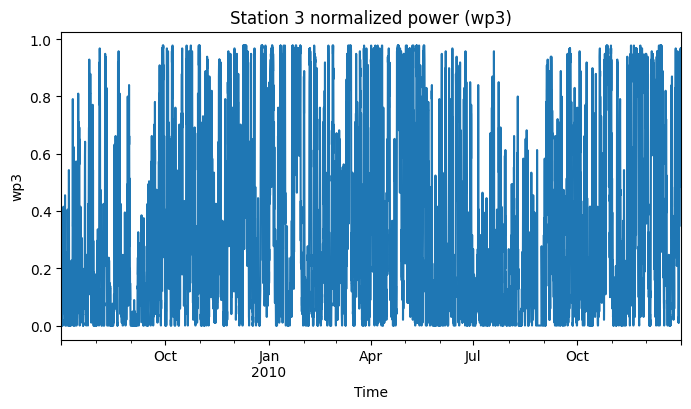

In [5]:

df["wp3"].plot(title="Station 3 normalized power (wp3)")
plt.xlabel("Time")
plt.ylabel("wp3")
plt.show()


## 2. Feature engineering (wind + time + multi-lag AR)

In [6]:

def add_time_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    idx = df.index

    df["hour"] = idx.hour
    df["dayofyear"] = idx.dayofyear

    # Cyclic encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

    return df

df_feat = add_time_features(df)

# ---- Add multi-lag autoregressive features: wp3(t-1)...wp3(t-N_LAGS) ----
for lag in range(1, N_LAGS + 1):
    df_feat[f"wp3_lag{lag}"] = df_feat["wp3"].shift(lag)

# Drop first N_LAGS rows where some lags are NaN
df_feat = df_feat.dropna(subset=[f"wp3_lag{lag}" for lag in range(1, N_LAGS + 1)])

cols_to_show = ["u", "v", "ws", "hors", "hour", "dayofyear"] + [f"wp3_lag{lag}" for lag in range(1, N_LAGS + 1)] + ["wp3"]
df_feat[cols_to_show].head()


,u,v,ws,hors,hour,dayofyear,wp3_lag1,wp3
2009-07-01 02:00:00,2.96,-2.12,3.65,2,2,182,0.257,0.178
2009-07-01 03:00:00,2.47,-2.02,3.19,3,3,182,0.178,0.109
2009-07-01 04:00:00,2.05,-2.06,2.90,4,4,182,0.109,0.079
2009-07-01 05:00:00,1.72,-2.11,2.72,5,5,182,0.079,0.099
2009-07-01 06:00:00,1.53,-2.07,2.57,6,6,182,0.099,0.069


In [7]:

target_col = "wp3"

forecast_features = ["u", "v", "ws", "hors", "hour_sin", "hour_cos", "doy_sin", "doy_cos"]
ar_features = [f"wp3_lag{lag}" for lag in range(1, N_LAGS + 1)]

# 1) Forecast-only features (for comparison)
X_all_forecast = df_feat[forecast_features].copy()

# 2) Forecast + multi-lag AR features
X_all_ar = df_feat[forecast_features + ar_features].copy()

y_all = df_feat[target_col].values

print("Forecast-only X shape:", X_all_forecast.shape)
print("Forecast + multi-lag AR X shape:", X_all_ar.shape)


Forecast-only X shape: (13174, 8)
Forecast + multi-lag AR X shape: (13174, 9)


## 3. Train/validation split (by time)

In [8]:

n = len(df_feat)
split_idx = int(0.8 * n)

X_train_forecast = X_all_forecast.iloc[:split_idx]
X_valid_forecast = X_all_forecast.iloc[split_idx:]

X_train_ar = X_all_ar.iloc[:split_idx]
X_valid_ar = X_all_ar.iloc[split_idx:]

y_train = y_all[:split_idx]
y_valid = y_all[split_idx:]

print("Train size:", X_train_ar.shape, "Validation size:", X_valid_ar.shape)


Train size: (10539, 9) Validation size: (2635, 9)


## 4. Persistence baseline

In [9]:

# Persistence: predict wp3(t) = wp3(t-1)
y_all_series = df_feat[target_col]
y_persist = y_all_series.shift(1)

# Validation slice (same window as X_valid_ar)
y_persist_valid = y_persist.iloc[split_idx:]
y_valid_aligned = y_all_series.iloc[split_idx:]

mask = ~y_persist_valid.isna()
y_persist_valid = y_persist_valid[mask]
y_valid_aligned = y_valid_aligned[mask]

rmse_persist = root_mean_squared_error(y_valid_aligned, y_persist_valid)
print(f"Persistence RMSE on validation: {rmse_persist:.4f}")


Persistence RMSE on validation: 0.1017


## 5. Decision Tree regression models

### 5.1 Basic DecisionTreeRegressor (forecast + multi-lag AR)

In [10]:

tree_basic = DecisionTreeRegressor(random_state=0)
tree_basic.fit(X_train_ar, y_train)

y_pred_basic = tree_basic.predict(X_valid_ar)
rmse_basic = root_mean_squared_error(y_valid, y_pred_basic)
r2_basic = r2_score(y_valid, y_pred_basic)

print(f"Basic DecisionTree (forecast + multi-lag AR) – RMSE: {rmse_basic:.4f}, R²: {r2_basic:.4f}")


Basic DecisionTree (forecast + multi-lag AR) – RMSE: 0.1359, R²: 0.8305


### 5.2 Tuning DecisionTreeRegressor (GridSearchCV + TimeSeriesSplit)

In [11]:

param_grid = {
    "max_depth": [3, 5, 7, 9, 12, None],
    "min_samples_leaf": [1, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=4)

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train_ar, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_valid_ar)
rmse_best = root_mean_squared_error(y_valid, y_pred_best)
r2_best = r2_score(y_valid, y_pred_best)

print(f"Tuned DecisionTree (forecast + multi-lag AR) – RMSE: {rmse_best:.4f}, R²: {r2_best:.4f}")


Best params: {'max_depth': 5, 'min_samples_leaf': 10}
Best CV RMSE: 0.09853895384901923
Tuned DecisionTree (forecast + multi-lag AR) – RMSE: 0.1006, R²: 0.9071


## 6. Diagnostics – impact of multi-lag AR in Decision Trees

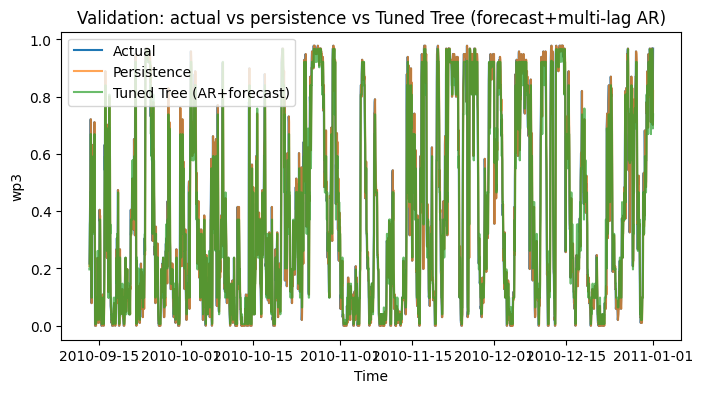

In [12]:

plt.plot(df_feat.index[split_idx:], y_valid, label="Actual")
plt.plot(df_feat.index[split_idx:], y_persist_valid, label="Persistence", alpha=0.7)
plt.plot(df_feat.index[split_idx:], y_pred_best, label="Tuned Tree (AR+forecast)", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("wp3")
plt.title("Validation: actual vs persistence vs Tuned Tree (forecast+multi-lag AR)")
plt.legend()
plt.show()


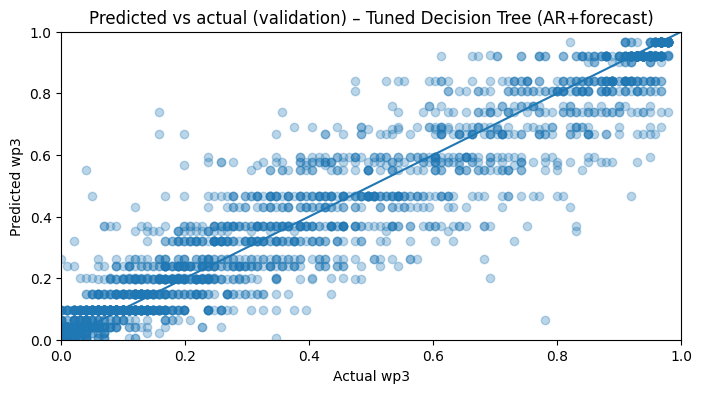

In [13]:

plt.scatter(y_valid, y_pred_best, alpha=0.3)
lims = [0, 1]
plt.plot(lims, lims)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual wp3")
plt.ylabel("Predicted wp3")
plt.title("Predicted vs actual (validation) – Tuned Decision Tree (AR+forecast)")
plt.show()
